<a href="https://colab.research.google.com/github/Medynal/thing/blob/main/PRAC_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Brownfield Redevelopment Tax Credits are incentives given to encourage the clean-up and redevelopment of brownfields i.e. properties that are abandoned or underutilized due to contamination or perceived contamination.
The Department of Taxation and Finance annually produces a mandated report of taxpayers claiming Brownfield Redevelopment credit to offset their tax. The aim of this analysis is to explore the policy impact in New York City (does the program improve the number of brownfields developed annually in New York City?)


In [140]:
!pip -q install gdown==4.6.0
import gdown
gdrive_link = 'https://drive.google.com/file/d/1zcUPAntkZVHe3rtbC0sOX_Etv56Kdx4E/view?usp=sharing'
file_id= '1zcUPAntkZVHe3rtbC0sOX_Etv56Kdx4E'
downloadable_link= f'https://drive.google.com/uc?id={file_id}'
gdown.download(downloadable_link, output= 'NYC_brownfields.csv')
print ('download complete!' )

Downloading...
From: https://drive.google.com/uc?id=1zcUPAntkZVHe3rtbC0sOX_Etv56Kdx4E
To: /content/NYC_brownfields.csv
100%|██████████| 237k/237k [00:00<00:00, 5.91MB/s]

download complete!


In [141]:
import pandas as pd
import numpy as np
import re

brownfield_df= pd.read_csv('NYC_brownfields.csv')
print(f'shape: {brownfield_df.shape}\n')
print(f'Missin Values:\n {brownfield_df.isna().sum()}')
print('\nData Information:')
brownfield_df.info()

shape: (1461, 19)

Missin Values:
 Calendar Year                                0
Tax Year                                     0
Taxpayer Name                                0
Project Site Code                            0
Project Site Name                            0
Notes                                      389
DEC Region                                   0
County                                       0
Municipality                                 0
En-Zone                                      0
 Site Preparation Component Costs            1
Site Preparation Component Credit            1
 Tangible Property Component Costs           3
Tangible Property Component Credit           1
 OnSite Groundwater Remediation Cost         3
 OnSite Groundwater Remediation Credit       5
 Total Cost                                  1
 Total Credit                                0
Georeference                                 3
dtype: int64

Data Information:
<class 'pandas.core.frame.DataFrame'>
Ra

below are the description of each column
1. Calendar Year:Year when the project or credit was recorded.
2.	Tax Year: Fiscal year for which the tax credit applies.
3.	Taxpayer Name: Name of the company receiving the credit.
4.	Project Site Code: Unique ID for each brownfield site.
5.	Project Site Name:Name of the brownfield site.
6.	Notes:Remarks about the project or credit.
7.	DEC Region:The New York State Department of Environmental Conservation region where the brownfield is located.
8.	County: County where the brownfield site is based.
9.	Municipality: Local municipality (e.g., city, town) overseeing the site.
10.	En-Zone: Indicates if the site is within an “Environmental Zone” (areas targeted for economic redevelopment).
11.	Site Preparation Component Costs: Total cost of preparing the site (cleanup, demolition, etc.).
12.	Site Preparation Component Credit: Tax credit amount awarded for site preparation costs
13.	Tangible Property Component Costs: Costs related to new tangible assets (buildings, infrastructure).
14.	Tangible Property Component Credit: Tax credit amount awarded for tangible property investments.
15.	OnSite Groundwater Remediation Cost: Costs spent specifically on cleaning contaminated groundwater.
16.	OnSite Groundwater Remediation Credit:Tax credit amount awarded for groundwater cleanup.
17.	Total Cost: Sum of all costs for the project (preparation + tangible + remediation).
18.	Total Credit: Total amount of tax credits granted for the project.
19.	Georeference: Geolocation data (coordinates or reference ID) for mapping purposes.


In [142]:
#rename columns with long names for easy access.
brownfield_df.columns = brownfield_df.columns.str.strip()
brownfield_df.rename(columns={'Site Preparation Component Costs':'spc_cost',
                              'Site Preparation Component Credit':'spc_credit',
                              'Tangible Property Component Costs':'tpc_cost',
                              'Tangible Property Component Credit':'tpc_credit',
                              'OnSite Groundwater Remediation Cost':'ogrc_cost',
                              'OnSite Groundwater Remediation Credit':'ogrc_credit'},inplace=True)
brownfield_df.columns= brownfield_df.columns.str.lower().str.replace(' ', '_')

In [143]:
brownfield_df.head(3)

,calendar_year,tax_year,taxpayer_name,project_site_code,project_site_name,notes,dec_region,county,municipality,en-zone,spc_cost,spc_credit,tpc_cost,tpc_credit,ogrc_cost,ogrc_credit,total_cost,total_credit,georeference
0,2022,2021,NEW 470 LLC,C224242,New 470 Project,"4/, 7/",2,Kings,Brooklyn,No,0.0,0.0,103861.0,15579.0,0.0,0.0,103861.0,15579,POINT (-73.99036 40.69245)
1,2009,2008,EMPIRE GEN HOLDINGS INC,C442035,South 40 Site,NaN,4,Rensselaer,Rensselaer,No,700000.0,84000.0,0.0,0.0,0.0,0.0,700000.0,84000,POINT (-73.74127 42.64472)
2,2020,2019,NEW 470 LLC,C224242,New 470 Project,"4/, 7/",2,Kings,Brooklyn,No,2935248.0,821869.0,0.0,0.0,0.0,0.0,2935248.0,821869,POINT (-73.99036 40.69245)


Assumption: Most credit awarded are half of the cost accrued. therefore, it is assumed that:
Missing credit is half of the cost if available
Missing cost is twice the credit, if available
If both are missing, then both are zero.

For missing geospatial reference, it is assumed that project with the same project site code will have the same georeference code

In [144]:
#Data Cleaning
## dealing with mising values for cost and credit
def na_values(row, a, b): #define a function that returns half of cost if credit is missing and double the credit if course is missing
    if pd.isna(row[a]) and pd.notna(row[b]):
        row[a] = row[b]*2
    elif pd.notna(row[a]) and pd.isna(row[b]):
        row[b] = row[a]/2
    elif pd.isna(row[a]) and pd.isna(row[b]):
        row[a], row[b] = 0, 0
    return row
brownfield_df = brownfield_df.apply(na_values, axis=1, args=('spc_cost', 'spc_credit'))
brownfield_df = brownfield_df.apply(na_values, axis=1, args=('tpc_cost', 'tpc_credit'))
brownfield_df = brownfield_df.apply(na_values, axis=1, args=('ogrc_cost', 'ogrc_credit'))
#filling missing total cost and total credit
total_cost = brownfield_df['spc_cost'] + brownfield_df['tpc_cost'] + brownfield_df['ogrc_cost']
total_credit = brownfield_df['spc_credit'] + brownfield_df['tpc_credit'] + brownfield_df['ogrc_credit']
brownfield_df['total_cost']= brownfield_df['total_cost'].fillna(total_cost)
##recalculating total cost and total credit due to fixed missing values
brownfield_df['total_cost']= total_cost
brownfield_df['total_credit']= total_credit







Rows with missing georeference value has the same project site code (C622031). other rows with the same project site code has a georeference of POINT (-74.98433 43.0259)


In [145]:
## show rows with missing georefernce
brownfield_df[brownfield_df['georeference'].isna()]
##check for complete rows with the same project site code
brownfield_df[brownfield_df['project_site_code']== 'C622031']
brownfield_df['georeference']= brownfield_df['georeference'].fillna('POINT (-74.98433 43.0259)')
#fill missing notes
brownfield_df['notes']= brownfield_df['notes'].fillna('No notes available')


In [146]:
brownfield_df['dec_region']= 'Region '+ brownfield_df['dec_region'].astype('str')

In [147]:
##recheck for missing values
brownfield_df.isna().sum()

,0
calendar_year,0
tax_year,0
taxpayer_name,0
project_site_code,0
project_site_name,0
notes,0
dec_region,0
county,0
municipality,0
en-zone,0


In [148]:
## split the georefernce to longitude and latitude
def coordinate(g):
  g= g.strip()
  pattern = r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)'
  match = re.search(pattern, g)
  if match:
    longitude = float(match.group(1))
    latitude = float(match.group(2))
    return pd.Series([longitude, latitude])
  else:
    return pd.Series([None, None])

brownfield_df[['longitude', 'latitude']] = brownfield_df['georeference'].apply(coordinate)


In [149]:
## checking for missing values===> No missing values!
brownfield_df[brownfield_df['longitude'].isna()]


,calendar_year,tax_year,taxpayer_name,project_site_code,project_site_name,notes,dec_region,county,municipality,en-zone,...,spc_credit,tpc_cost,tpc_credit,ogrc_cost,ogrc_credit,total_cost,total_credit,georeference,longitude,latitude


In [150]:
## Drop column notes
brownfield_dffinal= brownfield_df.drop(columns='notes')
## checking final data details
print(f'shape: {brownfield_dffinal.shape}\n')
print(f'Missin Values:\n {brownfield_dffinal.isna().sum()}')
print('\nData Information:')
brownfield_dffinal.info()
print('\nNumber of Unique Values in each column:')
print(brownfield_dffinal.nunique())



shape: (1461, 20)

Missin Values:
 calendar_year        0
tax_year             0
taxpayer_name        0
project_site_code    0
project_site_name    0
dec_region           0
county               0
municipality         0
en-zone              0
spc_cost             0
spc_credit           0
tpc_cost             0
tpc_credit           0
ogrc_cost            0
ogrc_credit          0
total_cost           0
total_credit         0
georeference         0
longitude            0
latitude             0
dtype: int64

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   calendar_year      1461 non-null   int64  
 1   tax_year           1461 non-null   int64  
 2   taxpayer_name      1461 non-null   object 
 3   project_site_code  1461 non-null   object 
 4   project_site_name  1461 non-null   object 
 5   dec_region         1461 n

In [151]:
##Save cleaned data
brownfield_dffinal.to_csv('NYC_brownfields_cleaned.csv', index=False)

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
pio.templates.default = "ggplot2"
#plt.style.use('ggplot')

Descriptive analysis of the dataset.

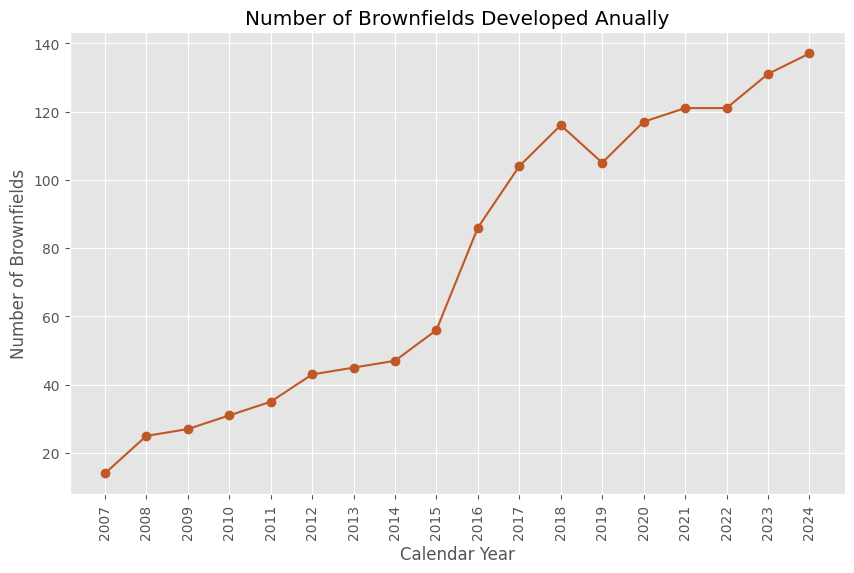

In [173]:
#Data Visualisation
##Visualise project trend
project_trend= brownfield_dffinal.groupby('calendar_year')['project_site_code'].nunique().reset_index()
project_trend.head(3)
plt.figure(figsize=(10,6))
c_year= brownfield_dffinal['calendar_year'].unique()
plt.plot(project_trend['calendar_year'], project_trend['project_site_code'], marker= 'o',color= '#bf5824')
plt.xticks(c_year, rotation= 90)
plt.title('Number of Brownfields Developed Anually')
plt.xlabel('Calendar Year')
plt.ylabel('Number of Brownfields')
plt.show()


In [162]:
#Total Cost Vs Total Credit over time
total_cost_credit= brownfield_dffinal.groupby('calendar_year')[['total_cost', 'total_credit']].sum().reset_index()
total_cost_credit= total_cost_credit.melt(id_vars= 'calendar_year', value_vars= ['total_cost', 'total_credit'], var_name= 'type', value_name= 'amount')
total_bar= px.bar(data_frame= total_cost_credit,
                       x= 'calendar_year',
                       y= 'amount',
                       color= 'type',
                       barmode= 'group',
                       color_discrete_map={'total_cost':'#2A9D8F', 'total_credit':'#bf5824'},
                       labels={'calendar_year':'Calendar Year', 'amount':'Amount', 'type':'Type'},
                       title= 'Total Cost Vs Total Credit over time')
total_bar.update_xaxes(tickangle=90, tick0= 2007, dtick= 1)
total_bar.show()


Top Taxpayers/Developers – Which companies received the most credits or completed the most projects?

In [178]:
#Top taxpayer by project developed
taxpayer_counts = brownfield_dffinal.groupby(['calendar_year', 'taxpayer_name'])['project_site_code'].nunique().reset_index(name='Number_of_projects')
##Find the top taxpayer per year
top_taxpayer = taxpayer_counts.loc[taxpayer_counts.groupby('calendar_year')['Number_of_projects'].idxmax()].reset_index(drop=True)
top_taxpayer.head(3)
top_taxpayer_bar= px.bar(data_frame= top_taxpayer,
                       x= 'calendar_year',
                       y= 'Number_of_projects',
                       color= 'taxpayer_name',
                       color_discrete_sequence= px.colors.qualitative.Pastel,
                       text= 'Number_of_projects',
                       labels={'calendar_year':'Calendar Year', 'Number_of_projects':'Number of Brownfields Developed', 'taxpayer_name':'Taxpayer Name'},
                       title= 'Top Taxpayer by project developed')

top_taxpayer_bar.update_xaxes(tickangle=90, tick0= 2007, dtick= 1)
top_taxpayer_bar.show()

In [181]:
#Top taxpayer by project credit
taxpayer_ccounts = brownfield_dffinal.groupby(['calendar_year', 'taxpayer_name'])['total_credit'].sum().reset_index()
##Find the top taxpayer per year
topc_taxpayer = taxpayer_ccounts.loc[taxpayer_ccounts.groupby('calendar_year')['total_credit'].idxmax()].reset_index(drop=True)
topc_taxpayer.head(3)
topc_taxpayer_bar= px.bar(data_frame= topc_taxpayer,
                       x= 'calendar_year',
                       y= 'total_credit',
                       color= 'taxpayer_name',
                       color_discrete_sequence= px.colors.qualitative.Pastel,
                       labels={'calendar_year':'Calendar Year', 'total_credit':'Total Credit Earned', 'taxpayer_name':'Taxpayer Name'},
                       title= 'Top Taxpayer by Total Credit Earned')

topc_taxpayer_bar.update_xaxes(tickangle=90, tick0= 2007, dtick= 1)
topc_taxpayer_bar.update_traces(hovertemplate='%{y:,}')
topc_taxpayer_bar.show()

In [154]:
#Trend of brownfields developed anually based on environment zone
zone_trend= brownfield_dffinal.groupby(['calendar_year','en-zone'])['project_site_code'].nunique().reset_index()
print(zone_trend)
zone_trend_bar= px.bar(data_frame= zone_trend,
                       x= 'calendar_year',
                       y= 'project_site_code',
                       color= 'en-zone',
                       barmode= 'relative',
                       color_discrete_map={'No':'#2A9D8F', 'Yes':'#bf5824'},
                       text= 'project_site_code',
                       labels={'calendar_year':'Calendar Year', 'project_site_code':'Number of Brownfields Developed', 'en-zone':'Environmental Zone'},
                       title= 'Trend of Brownfields Developed Anually based on Environment Zone')
zone_trend_bar.update_xaxes(tickangle=90, tick0= 2007, dtick= 1)
zone_trend_bar.show()




    calendar_year en-zone  project_site_code
0            2007      No                  7
1            2007     Yes                  7
2            2008      No                 15
3            2008     Yes                 10
4            2009      No                 12
5            2009     Yes                 15
6            2010      No                 17
7            2010     Yes                 14
8            2011      No                 18
9            2011     Yes                 17
10           2012      No                 19
11           2012     Yes                 24
12           2013      No                 20
13           2013     Yes                 26
14           2014      No                 17
15           2014     Yes                 30
16           2015      No                 23
17           2015     Yes                 33
18           2016      No                 45
19           2016     Yes                 41
20           2017      No                 54
21        

In [155]:
## Number of Brownfields Developed so far by DEC Region
region_trend= brownfield_dffinal.groupby(['dec_region', 'en-zone'])['project_site_code'].nunique().reset_index()
region_trend_bar= px.bar(data_frame= region_trend,
                       x= 'dec_region',
                       y= 'project_site_code',
                       color= 'en-zone',
                       barmode= 'relative',
                       color_discrete_map={'No':'#2A9D8F', 'Yes':'#bf5824'},
                       text= 'project_site_code',
                       labels={'dec_region':'Department of Environmental Conservation region ', 'project_site_code':'Number of Brownfields Developed', 'en-zone':'Environmental Zone'},
                       title= 'Trend of Brownfields Developed in each DEC region based on Environment Zone')
region_trend_bar.show()


In [157]:
# Top ten counties base on brownfield developed
top_ten_counties= pd.pivot_table(brownfield_dffinal,
                                 index= 'county', columns= 'en-zone',values= 'project_site_code',
                                 fill_value=0, aggfunc= 'nunique').reset_index()
top_ten_counties['total projects']= top_ten_counties['Yes']+top_ten_counties['No']
top_ten_counties= top_ten_counties.sort_values(by= 'total projects', ascending= False).head(10)
#.reset_index()
top_ten_data= top_ten_counties.melt(id_vars= 'county', value_vars= ['Yes', 'No'], var_name= 'en-zone', value_name= 'brownfields')
top_ten_bar= px.bar(data_frame= top_ten_data,
                       x= 'brownfields',
                       y= 'county',
                       color= 'en-zone',
                       barmode= 'relative',
                       color_discrete_map={'No':'#2A9D8F', 'Yes':'#bf5824'},
                       text= 'brownfields',
                       labels={'brownfieds':'Number of Brownfields Developed (2007-2024) ', 'county':'County', 'en-zone':'Environmental Zone'},
                       title= 'Top ten counties base on brownfield developed')
top_ten_bar.show()


